In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

RANDOM_SEED = 20090425

In [2]:
from io import StringIO

In [3]:
data_string = """
Drugs   Score
0   1.17   78.93
1   2.97   58.20
2   3.26   67.47
3   4.69   37.47
4   5.83   45.65
5   6.00   32.92
6   6.41   29.97
"""

In [7]:
lsd_and_math = pd.read_table(StringIO(data_string), sep="\s+", index_col=0)

In [8]:
lsd_and_math

,Drugs,Score
0,1.17,78.93
1,2.97,58.20
2,3.26,67.47
3,4.69,37.47
4,5.83,45.65
5,6.00,32.92
6,6.41,29.97


In [9]:
sum_of_squares = lambda o, x, y,: np.sum((y - o[0] - o[1]*x) **2)

In [10]:
sum_of_squares([0,1], lsd_and_math.Drugs, lsd_and_math.Score)

17159.8154

In [11]:
x, y = lsd_and_math.T.values
b0, b1 = fmin(sum_of_squares, [0, 1], args=(x, y))
b0, b1

Optimization terminated successfully.
         Current function value: 253.881329
         Iterations: 97
         Function evaluations: 179


(89.12390920980424, -9.00946965833095)

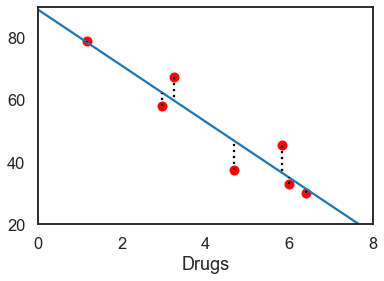

In [12]:
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8), ylim=(20,90))
ax.plot([0,10], [b0, b0+b1*10])
for xi, yi in zip(x,y):
    ax.plot([xi]*2, [yi, b0+b1*xi], 'k:')

In [13]:
sum_of_absval = lambda o, x, y: np.sum(np.abs(y - o[0] - o[1]*x))

Optimization terminated successfully.
         Current function value: 31.692066
         Iterations: 137
         Function evaluations: 264

intercept:  9e+01, slope:  -9.3


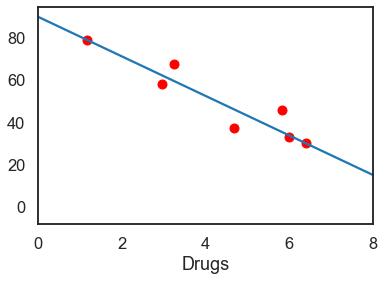

In [14]:
b0, b1 = fmin(sum_of_absval, [0,0], args=(x,y))
print('\nintercept:  {0:.2}, slope:  {1:.2}'.format(b0,b1))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
ax.plot([0,10], [b0, b0+b1*10])

In [15]:
sum_squares_quad = lambda o, x, y: np.sum((y - o[0] - o[1]*x - o[2]*(x**2)) **2)

Optimization terminated successfully.
         Current function value: 251.093792
         Iterations: 177
         Function evaluations: 319

intercept:  9.2e+01, x:  -1.1e+01, x2:  0.24


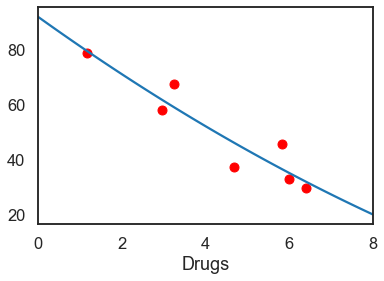

In [16]:
b0, b1, b2 = fmin(sum_squares_quad, [1, 1, -1], args=(x,y))
print('\nintercept:  {0:.2}, x:  {1:.2}, x2:  {2:.2}'.format(b0,b1, b2))
ax = lsd_and_math.plot(x='Drugs', y='Score', style='ro', legend=False, xlim=(0,8))
xvals = np.linspace(0, 8, 100)
ax.plot(xvals, b0 + b1*xvals + b2*(xvals**2))

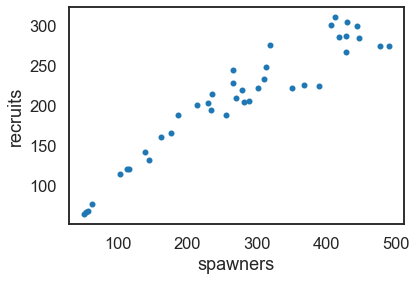

In [17]:
salmon = pd.read_table("salmon.dat", delim_whitespace=True, index_col=0)
salmon.plot.scatter(x='spawners', y='recruits');

(0.0, 100.0)

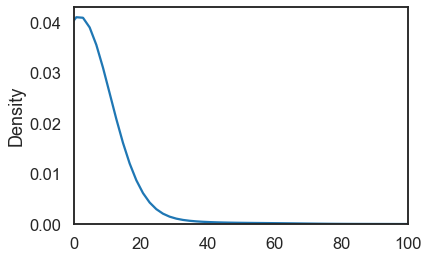

In [37]:
from pymc3 import HalfCauchy

ax = sns.kdeplot(HalfCauchy.dist(1).random(size=10000), gridsize=2000)
ax.set_xlim(0, 100)

In [38]:
from pymc3 import Normal, Model

with Model() as drugs_model:
    
    intercept = Normal('intercept', 0, sd=100)
    slope = Normal('slope', 0, sd=100)
    o = HalfCauchy('o', 1)

In [39]:
with drugs_model:
    u = intercept + slope * x
    score = Normal('score', u, sd=o, observed=y)

In [40]:
from pymc3 import sample

with drugs_model:
    drugs_sample = sample(1000, random_seed=RANDOM_SEED)

C:\Users\008010636\.conda\envs\pymc_env\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\008010636\.conda\envs\pymc_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\008010636\.conda\envs\pymc_env\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o, slope, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6173466884478626, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7212742054321954, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\008010636\.conda\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


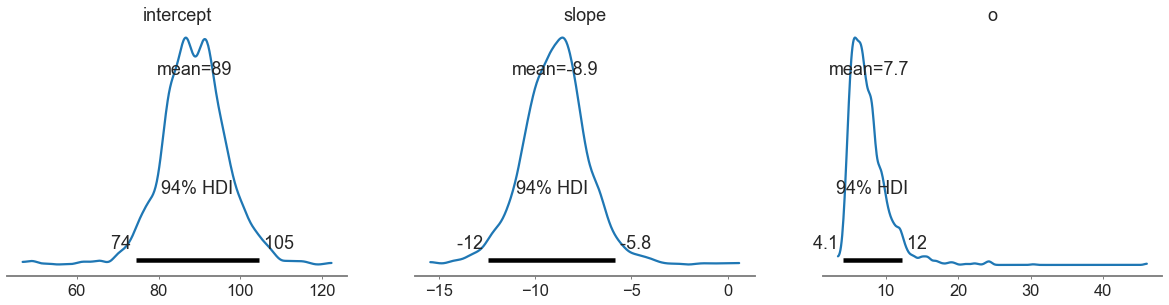

In [42]:
from pymc3 import plot_posterior

plot_posterior(drugs_sample[500:]);

In [43]:
from pymc3 import sample_ppc

with drugs_model:
    drugs_ppc = sample_ppc(drugs_sample, 1000)

ImportError: cannot import name 'sample_ppc' from 'pymc3' (C:\Users\008010636\.conda\envs\pymc_env\lib\site-packages\pymc3\__init__.py)

In [44]:
from pymc3 import sample_posterior_predictive

with drugs_model:
    drugs_ppc = sample_posterior_predictive(drugs_sample, 1000)

C:\Users\008010636\.conda\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [46]:
drugs_ppc['score'].shape

(1000, 7)

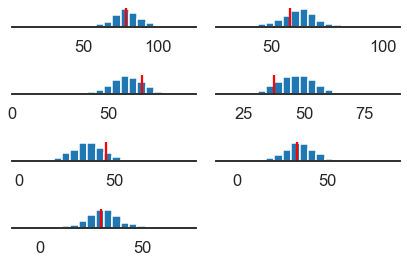

In [47]:
fig, axes = plt.subplots(4, 2)
axes_flat = axes.flatten()

for ax, real_data,  sim_data in zip(axes_flat[:-1], y, drugs_ppc['score'].T):
    ax.hist(sim_data, bins=20)
    ax.vlines(real_data,  *ax.get_ylim(), colors='red')
    ax.set_yticklabels([])
    sns.despine(left=True)
    
axes_flat[-1].axis('off')
plt.tight_layout()

## Jonathan Doolittle